# ZYu Data Helper 1

## Load files to `./train/` and create `/train/labels.json`

STEPS

First unzip `lines.tgz` into folder "data/line_data", also put the file `lines.txt` there.



- Read `line.txt` into a data-frame, which will serve as `index` to data-files

- Choose some files from the `index` to serve as train data

- Copy those files to `data/train`

- Create `labels.json` and place it in `data/train`

In [30]:
import warnings
warnings.filterwarnings('ignore')

import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split

import json

# Preliminary EDA

In [5]:
!head -23 lines.txt

#--- lines.txt ---------------------------------------------------------------#
#
# iam database line information
#
# format: a01-000u-00 ok 154 19 408 746 1663 91 A|MOVE|to|stop|Mr.|Gaitskell|from
#
#     a01-000u-00  -> line id for form a01-000u
#     ok              -> result of word segmentation
#                            ok: line is correctly segmented
#                            err: segmentation of line has one or more errors
#
#                        notice: if the line could not be properly segmented
#                                the transcription and extraction of the whole
#                                line should not be affected negatively
#
#     154             -> graylevel to binarize line
#     19              -> number of components for this line
#     408 746 1663 91 -> bounding box around this line in x,y,w,h format
#
#     A|MOVE|to|stop|Mr.|Gaitskell|from
#                     -> transcription for this line. word tokens are separated
#                    

In [6]:
!head -25 lines_copy.txt

a01-000u-00 ok 154 19 408 746 1661 89 A|MOVE|to|stop|Mr.|Gaitskell|from
a01-000u-01 ok 156 19 395 932 1850 105 nominating|any|more|Labour|life|Peers
a01-000u-02 ok 157 16 408 1106 1986 105 is|to|be|made|at|a|meeting|of|Labour
a01-000u-03 err 156 23 430 1290 1883 70 M Ps|tomorrow|.|Mr.|Michael|Foot|has
a01-000u-04 ok 157 20 395 1474 1830 94 put|down|a|resolution|on|the|subject
a01-000u-05 err 156 21 379 1643 1854 88 and|he|is|to|be|backed|by|Mr.|Will
a01-000u-06 ok 159 20 363 1825 2051 87 Griffiths|,|M P|for|Manchester|Exchange|.
a01-000x-00 ok 182 30 375 748 1561 148 A|MOVE|to|stop|Mr.|Gaitskell|from|nominating
a01-000x-01 ok 181 23 382 924 1595 148 any|more|Labour|life|Peers|is|to|be|made|at|a
a01-000x-02 ok 181 30 386 1110 1637 140 meeting|of|Labour|0M Ps|tomorrow|.|Mr.|Michael
a01-000x-03 ok 179 22 375 1276 1584 154 Foot|has|put|down|a|resolution|on|the|subject
a01-000x-04 ok 173 25 397 1458 1647 148 and|he|is|to|be|backed|by|Mr.|Will|Griffiths|,
a01-000x-05 ok 173 16 393 1635 1082 

### NOTE

There are lines (4, 13 ...) with label containing spaces that can cause trouble when spliting by " ":

`a01-000x-05 ok 173 16 393 1635 1082 155 0M P|for|Manchester|Exchange|.`

EDA shows 13317 rows have 9 fields, but there are 23 rows with 10 fields, and 13 rows with 11 fields, these will cause trouble if reading the 'lines_copy.txt' file into CSV.

In [7]:
# SHOW LINES WITH > 9 FIELDS
# count the number of fields if delimited by " "
from collections import defaultdict

file_in = 'lines_copy.txt'

fhand = open(file_in)

num_count = defaultdict(int)

for line in fhand:
    num = len(line.split(" "))
    num_count[num] +=1
    if num > 9:
        print(line)

fhand.close()

num_count

a01-000u-03 err 156 23 430 1290 1883 70 M Ps|tomorrow|.|Mr.|Michael|Foot|has

a01-000u-06 ok 159 20 363 1825 2051 87 Griffiths|,|M P|for|Manchester|Exchange|.

a01-000x-02 ok 181 30 386 1110 1637 140 meeting|of|Labour|0M Ps|tomorrow|.|Mr.|Michael

a01-000x-05 ok 173 16 393 1635 1082 155 0M P|for|Manchester|Exchange|.

a01-003-01 ok 176 29 319 1078 1787 126 large|majority|of|Labour|M Ps|are|likely|to

a01-003-03 ok 176 28 316 1441 1750 70 Foot's|line|will|be|that|as|Labour|M Ps

a01-003u-02 ok 161 21 356 1162 1908 96 M Ps|are|likely|to|turn|down|the|Foot-

a01-003u-04 ok 161 13 351 1515 1869 103 be|that|as|Labour|M Ps|opposed|the

a01-003x-01 ok 176 28 307 1046 1831 170 large|majority|of|Labour|0M Ps|are|likely|to|turn

a01-003x-03 err 169 26 325 1423 1839 128 will|be|that|as|Labour|0M Ps|opposed|the|Govern-

a01-030-02 ok 176 20 305 1083 1815 100 M Ps|yesterday|:|"|I|have|no|knowledge|of|secret|negotiations|.|"

a01-030u-02 err 170 22 330 1163 1856 93 meeting|.|But|he|told|M Ps|yesterd

defaultdict(int, {9: 13317, 10: 23, 11: 13})

# 1. Read meta-data into a dataframe

In [9]:
file_in = 'lines_copy.txt'

fhand = open(file_in)
data_list = [] 

for line in fhand:
    item = line.split(" ")   # split the line
    num = len(item)          # number of fields if line delimited by " "
    
    if num == 9:             # good lines
        label = item[8]      # last field is label if only 9 field
    else:                    # bad lines with spaces in "label"
        label = " ".join(item[8:])    # join the remaining fields - this is label

    new_data  ={'id': item[0], 
                'wseg_status': item[1], 
                'graylevel': int(item[2]), 
                'num_components': int(item[3]), 
                'x': int(item[4]), 
                'y': int(item[5]), 
                'w': int(item[6]), 
                'h': int(item[7]), 
                'label': label.rstrip().replace("|", " ")}   # remove "\n", replace "|" with " "
    
    data_list.append(new_data)
    
fhand.close()

df = pd.DataFrame(data_list, 
                  columns=['id', 'wseg_status', 'graylevel', 'num_components', 'x', 'y', 'w', 'h', 'label'])

df.head()

,id,wseg_status,graylevel,num_components,x,y,w,h,label
0,a01-000u-00,ok,154,19,408,746,1661,89,A MOVE to stop Mr. Gaitskell from
1,a01-000u-01,ok,156,19,395,932,1850,105,nominating any more Labour life Peers
2,a01-000u-02,ok,157,16,408,1106,1986,105,is to be made at a meeting of Labour
3,a01-000u-03,err,156,23,430,1290,1883,70,M Ps tomorrow . Mr. Michael Foot has
4,a01-000u-04,ok,157,20,395,1474,1830,94,put down a resolution on the subject


In [10]:
df.dtypes

id                object
wseg_status       object
graylevel          int64
num_components     int64
x                  int64
y                  int64
w                  int64
h                  int64
label             object
dtype: object

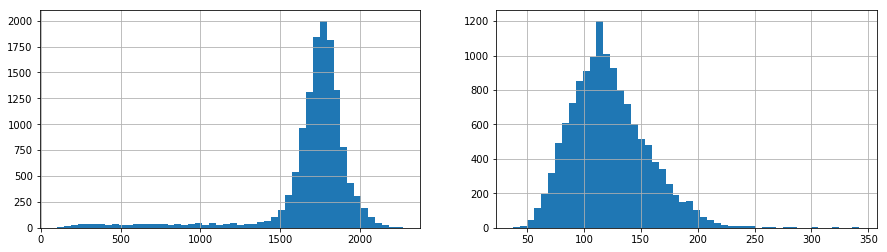

In [11]:
plt.figure(1, figsize=(15,4))
plt.subplot(121)
df['w'].hist(bins=50)
plt.subplot(122)
df['h'].hist(bins=50)
plt.show()

# 2. Choose files from the dataframe

- `wseg_status` has 11344 `ok`, 2009 `err`

- perform a random split on our data

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2)

print(df_train.shape)
print(df_test.shape)

df_test.head()

(10682, 9)
(2671, 9)


,id,wseg_status,graylevel,num_components,x,y,w,h,label
9797,k04-010-08,ok,145,14,329,2296,1775,151,"watching her intently , and turning"
2249,b04-054-06,ok,186,22,310,1822,956,105,company will sign on again .
10975,m02-069-01,ok,190,52,373,1082,1830,116,"with time instil the reverence which , on Eart..."
9169,h07-078a-05,err,135,18,182,1557,1685,154,"and other materials , and the shortage of"
7168,g06-026f-00,err,191,26,380,722,1716,88,A pleasant life truly ! ... It so happens that...


# 3. Copy the chosen files to the destination and create json

For example, the first line:

- source: `./line_data/a03/a03-066/a03-066-01.png`

- destination: `./train/a03-066-01.png`

- label: `remove|these|doubts|,|and|to|persuade|the`

Work flow:

- initialize `file_list={}`

- loop through each line in the data frame

- use `id` field to create `source` and `destination`, `file_name`

- use `label` to create `label`

- copy `source` to `destination`

- add `{file_name: label}` to `file_list`

- create `labels.json` and put it in `./train`



### Define helper functions

In [19]:
def clean_folder(destination_dir):
    """
    only delete files and to used the os.path.join() method  
    If you also want to remove subdirectories, uncomment the elif statement.
    """
    
    import os, shutil
    folder = destination_dir
    
    count = 0
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
                count += 1
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
    print("Successfully removed", count, "files")        
    

def copy_files(df, source_dir, destination_dir):
    """
    copying files from source to destionation
    INPUT: df is a dataframe containing file information
    OUTPUT: json_list of {file_name:file_label} pairs    
    """

    from shutil import copy2
    json_dict = dict()

    for i in tnrange(df.shape[0], desc='copying files'):    

        # read data from each row
        file_data = df.iloc[i]            # each line in dataframe
        file_id = file_data['id']         # data for file
        file_name = file_id + '.png'      # file_name
        file_label = file_data['label']   # label
        
        # create source and destination 
        id_pc = file_id.split("-")
        source = source_dir + id_pc[0] + "/" + id_pc[0] + "-" + id_pc[1] + "/" + file_name
        destination = destination_dir  + file_name

        # copy source to destination
        copy2(source, destination)

        # append the {file_name: file_label} to json_list
        json_dict[file_name]= file_label

    return json_dict

def write_json_file(destination_dir, json_dict):
    """
    write json to the 'labels.json file in the destination directory
    """

    with open(destination_dir + 'labels.json', 'w') as fout:
        json.dump(json_dict, fout)
        
    print(destination_dir+'labels.json has been created.')

### Copy files listed in the input dataframe to destination

In [20]:
source_dir = './line_data/'
destination_dir = './train/'

In [22]:
# OPTIONAL: clean the destination folder if needed
clean_folder(destination_dir)

Successfully removed 0 files


In [23]:
# copying files from source to destination
json_dict = copy_files(df_train, source_dir, destination_dir)

print("Copied", len(json_dict), "files.")


Copied 10682 files.


In [24]:
# take a look
!ls train | wc 

  10682   10682  162515


### Write json to `labels.json` and put it in destination directory

In [25]:
write_json_file(destination_dir, json_dict)

./train/labels.json has been created.


In [42]:
with open('./train/labels.json') as f:
    train_json = json.load(f)
    
for key, val in list(train_json.items())[0:10]:
    print('{:20s}    {}'.format(key, val))

l04-012-03.png          He felt a glow of happiness steal over him .
j06-022-03.png          at the surface . Among other copepods
g04-043-07.png          co-operated , we made the little side chapel a place
e04-052-03.png          always used brass screws , which are more expensive . The first
g06-037r-09.png         the slightest effect .
a02-098-02.png          strong reaction from Sir Roy Welensky to any
a01-020u-06.png         seeking . African delegates are studying
b05-045-05.png          Martyrs ! " " CRICKET , " says the Oxford
g01-022-00.png          BUT NONE OF THESE DEDUCTIONS WERE
c03-084a-07.png         power of unbridled ambition .


### copy some files to `./test` as well

In [43]:
source_dir = './line_data/'
destination_dir = './test/'

# OPTIONAL: clean the destination folder if needed
clean_folder(destination_dir)

Successfully removed 0 files


In [44]:
# copying files from source to destination
json_dict = copy_files(df_test, source_dir, destination_dir)

print("Copied", len(json_dict), "files.")


Copied 2671 files.


In [45]:
write_json_file(destination_dir, json_dict)

./test/labels.json has been created.


In [47]:
with open('./test/labels.json') as f:
    train_json = json.load(f)
    
for key, val in list(train_json.items())[0:10]:
    print('{:20s}    {}'.format(key, val))

k04-010-08.png          watching her intently , and turning
b04-054-06.png          company will sign on again .
m02-069-01.png          with time instil the reverence which , on Earth , nature inspires ,
h07-078a-05.png         and other materials , and the shortage of
g06-026f-00.png         A pleasant life truly ! ... It so happens that I have an Italian
n06-123-07.png          got hotter as the day wore on and we rested
k07-166-03.png          You think that sculptor 's a god ?
g07-003b-06.png         Government's other representatives in the islands , while they
n02-045-06.png          sugary things you ought to have been there
j04-070-01.png          interfere . Strontium does not form a chloro-complex
